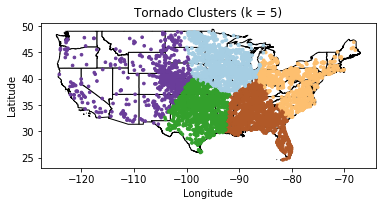

In [32]:
# Brian Garten
# visualizing type(s) of events clustered by location

import pandas as pd
import numpy as np
import geopandas as gpd
import webcolors
from matplotlib import colors, pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# event type to analyze, make in list format - options are: 
    #['Flash Flood' 'Thunderstorm Wind' 'Tornado' 'Hail' 'Flood'
    # 'Lightning' 'Heavy Rain' 'Funnel Cloud' 'Debris Flow' 'Marine Thunderstorm Wind'
    # 'Waterspout' 'Dust Devil' 'Marine High Wind' 'Marine Hail' 'Marine Strong Wind']
analyze = ['Tornado']
#analyze = ['Flash Flood', 'Thunderstorm Wind', 'Tornado' ,'Hail', 'Flood', 'Lightning', 'Heavy Rain' ,'Funnel Cloud' ,'Debris Flow' ,'Marine Thunderstorm Wind', 'Waterspout', 'Dust Devil', 'Marine High Wind', 'Marine Hail', 'Marine Strong Wind']
# number of clusters to use
num_clusters = 5
# the folder to place the output files
subfolder = 'Cluster Visuals'

# preparing and cleaning data
# import data
col_lst = ["STATE", "EVENT_TYPE", "BEGIN_LAT", "BEGIN_LON", "END_LAT", "END_LON"] # columns to read in
df = pd.read_csv("weather-data/StormEvents_details-ftp_v1.0_d2019_c20200416.csv", usecols=col_lst)
df = pd.concat([df, pd.read_csv("weather-data/StormEvents_details-ftp_v1.0_d2018_c20200317.csv", usecols=col_lst)])
df = pd.concat([df, pd.read_csv("weather-data/StormEvents_details-ftp_v1.0_d2017_c20200121.csv", usecols=col_lst)])
df = pd.concat([df, pd.read_csv("weather-data/StormEvents_details-ftp_v1.0_d2016_c20190817.csv", usecols=col_lst)])
df = pd.concat([df, pd.read_csv("weather-data/StormEvents_details-ftp_v1.0_d2015_c20191116.csv", usecols=col_lst)])

# restrict dataframe to a specific event type(s)
dfs=[]
for event in analyze:
    dfs.append(df[df.EVENT_TYPE == event])
df = pd.concat(dfs) # comment out this line to see all events
    
# remove outside the continental US
df = df.drop(df[(df.STATE == 'HAWAII') | (df.STATE == 'ALASKA') |
                (df.STATE == 'E PACIFIC') | (df.STATE == 'ATLANTIC NORTH') |
                (df.STATE == 'ATLANTIC SOUTH') | (df.STATE == 'GULF OF MEXICO') |
                (df.STATE == 'HAWAII WATERS') | (df.STATE == 'PUERTO RICO') |
                (df.STATE == 'VIRGIN ISLANDS') | (df.STATE == 'AMERICAN SAMOA')].index)
# remove any rows with missing data, then reset the index
df = df.dropna().reset_index(drop=True)

# calculate event mid point
df["MID_LAT"] = (df["BEGIN_LAT"]+df["END_LAT"]) / 2
df["MID_LON"] = (df["BEGIN_LON"]+df["END_LON"]) / 2
df = df.drop(columns=["BEGIN_LAT","END_LAT","BEGIN_LON","END_LON"])


# create a geodataframe from the dataframe's lat and lon
gdf = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.MID_LON,df.MID_LAT))

# load in the map
usa = gpd.read_file('usmap-shapefiles/cb_2018_us_state_500k.shp')
# remove any shapes outside the lower 48 for the map
usa = usa.drop(usa[(usa.STUSPS == 'AK') | (usa.STUSPS == 'HI') | (usa.STUSPS == 'AS') |
                   (usa.STUSPS == 'VI') | (usa.STUSPS == 'MP') | (usa.STUSPS == 'PR') | (usa.STUSPS == 'GU')].index)
# draw outline
ax = usa.plot(color='white', edgecolor='black')

# create the clusters
X = gdf[['MID_LON','MID_LAT']]
clusters = KMeans(n_clusters = num_clusters).fit(X)
cluster_labels = clusters.labels_

# image details
norm = colors.Normalize(vmin=0, vmax=cluster_labels.max())
gdf.plot(ax=ax, markersize=7, c=plt.cm.Paired(norm(cluster_labels)))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(" & ".join(analyze)+' Clusters (k = '+str(num_clusters)+')')

# filename and image quality
plt.savefig(subfolder+"/"+" & ".join(analyze).lower()+"_cluster", dpi = 350)
plt.show;

In [33]:
# see how many samples are in each cluster
unique_elements, counts_elements = np.unique(cluster_labels, return_counts=True)
freq = pd.DataFrame(data = counts_elements, columns=['Samples'])
freq.index.name = 'Cluster'

# finds the mathematically closest color name to the given hex
def closest_color(req_color):
    min_color = {}
    for hex_name, name in webcolors.CSS3_HEX_TO_NAMES.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(hex_name)
        rd = (r_c-req_color[0]) ** 2
        gd = (g_c-req_color[1]) ** 2
        bd = (b_c-req_color[2]) ** 2
        min_color[rd+gd+bd] = name
    return min_color[min(min_color.keys())]

# adds colors to the dataframe
norm = colors.Normalize(vmin=0, vmax=len(freq))
clst = []
for i in range(len(freq)):
    clst.append(plt.cm.Paired(norm(i)))
    clst[i] = closest_color(tuple(255*x for x in clst[i][:3]))
freq['Color'] = clst

# move the csv to a separate file
freq.to_csv(subfolder+"/"+" & ".join(analyze).lower()+"_freq")
print(freq)

         Samples          Color
Cluster                        
0           1476      lightblue
1           1999     lightgreen
2            901    lightsalmon
3            770     darkorange
4           1870  darkslateblue


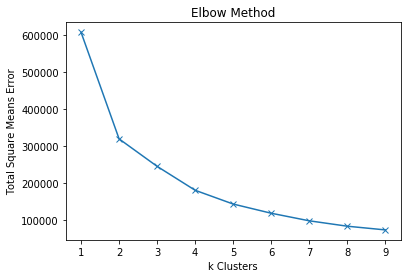

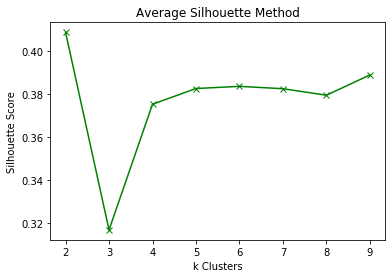

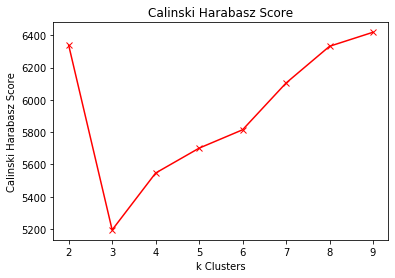

In [31]:
# Determine the number of clusters
clusters_max = 10
X = gdf[['MID_LON','MID_LAT']]

tsme = [] # elbow method - look for the "elbow" in the graph
s_scores = [] # silhouette score - look for the high points
ch_scores = [] # calinski harabasz score - look for the high points
for k in range(1,clusters_max):
    k_clusters = KMeans(n_clusters=k)
    k_clusters_tsme = k_clusters.fit(X)
    tsme.append(k_clusters_tsme.inertia_) # inertia gives the TMSE
    if (k >= 2): # the following methods require at least 2 clusters to analyze
        pred = k_clusters.fit_predict(gdf[['MID_LON','MID_LAT']])
        s_scores.append(silhouette_score(X, pred))
        ch_scores.append(calinski_harabasz_score(X, pred))
    
plt.plot(range(1,clusters_max), tsme, 'x-')
plt.xlabel('k Clusters')
plt.ylabel('Total Square Means Error')
plt.title('Elbow Method')
plt.savefig(subfolder+"/"+" & ".join(analyze).lower()+"_elbow", dpi = 350)
plt.show;
plt.figure()

plt.plot(range(2,clusters_max), s_scores, 'gx-')
plt.xlabel('k Clusters')
plt.ylabel('Silhouette Score')
plt.title('Average Silhouette Method')
plt.savefig(subfolder+"/"+" & ".join(analyze).lower()+"_silhouette", dpi = 350)
plt.show;
plt.figure()

plt.plot(range(2,clusters_max), ch_scores, 'rx-')
plt.xlabel('k Clusters')
plt.ylabel('Calinski Harabasz Score')
plt.title('Calinski Harabasz Score')
plt.savefig(subfolder+"/"+" & ".join(analyze).lower()+"_calinskiharabasz", dpi = 350)
plt.show;